Reference

Ehsan Hoseinzade, Saman Haratizadeh,
CNNpred: CNN-based stock market prediction using a diverse set of variables,
Expert Systems with Applications,
Volume 129,
2019,
Pages 273-285,
ISSN 0957-4174,
https://doi.org/10.1016/j.eswa.2019.03.029.

# <center><span style="color:blue">*Results Summary and Comparison to Reference*</span></center>

In [216]:
# F1-Macro Score compilation

results_df = pd.DataFrame.from_dict(f1_macro_score_2D, orient='index', columns=['Replica 2D CNN'])
results_df['Reference 2D CNN'] = [0.4975, 0.4944, 0.4885, 0.5002, 0.4914]
results_df['Replica 3D CNN'] = f1_macro_score.values()
results_df['Reference 3D CNN'] = [0.4979, 0.4931, 0.4751, 0.4846, 0.4837]

pd.options.display.float_format = '{:,.4f}'.format
results_df

,Replica 2D CNN,Reference 2D CNN,Replica 3D CNN,Reference 3D CNN
DJI,0.4965,0.4975,0.4989,0.4979
NASDAQ,0.5253,0.4944,0.4916,0.4931
NYSE,0.5429,0.4885,0.4877,0.4751
RUSSELL,0.5184,0.5002,0.4994,0.4846
S&P500,0.5418,0.4914,0.5050,0.4837


With our own implementation with some modifications to the proposed models, we were able to get slightly better F1-score over the board, compared to numbers reported in the reference study.

The performance comparison between 2D CNN and 3D CNN models are also very close to each other, and depending on the training initialization
can slightly trade places. F-Score for all entries (at least with our implementation, cannot find this information in the reference) have a
+- 0.25 margin.

In the reference study, the authors took 1 step further in the result analysis by and implementing a trading simulation using these CNN models. The authors showed that using these models have a lot of potential and are superior than some other previously published models in literature. While we will not be replicating the trading simulation part here (lack of description for the trading simulation), it is expected that our own implementations of the CNN models will be able to achieve similar or even better results in the authors' trading simulation.

# <center><span style="color:blue">*Install and Import the Necessary Libraries*</span></center>

In [ ]:
#!pip install --upgrade pip
#!pip install git
#!pip install tensorflow
#!pip install --upgrade git+https://github.com/tensorflow/docs

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import os
import datetime
from sklearn import metrics
from sklearn import preprocessing

print('Packages imported in')

Packages imported in


# <center><span style="color:blue">*Import, Inspect, and Clean Up Dataset*</span></center>

In [5]:
# Load in data
df_dji = pd.read_csv('DJI.csv')
df_nasdaq = pd.read_csv('NASDAQ.csv')
df_nyse = pd.read_csv('NYSE.csv')
df_russell = pd.read_csv('RUSSELL.csv')
df_sp = pd.read_csv('S&P.csv')

print('All dataframes loaded')

All dataframes loaded


In [6]:
df_dji.head()

,Date,Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,ROC_15,...,NZD,silver-F,RUSSELL-F,S&P-F,CHF,Dollar index-F,Dollar index,wheat-F,XAG,XAU
0,2009-12-31,10428.049805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.03,0.26,-1.08,-1.00,-0.11,-0.08,-0.06,-0.48,0.30,0.39
1,2010-01-04,10583.959961,NaN,0.014951,NaN,NaN,NaN,NaN,NaN,NaN,...,1.52,3.26,1.61,1.62,-0.57,-0.59,-0.42,3.12,3.91,2.10
2,2010-01-05,10572.019531,NaN,-0.001128,0.014951,NaN,NaN,NaN,NaN,NaN,...,-0.07,1.96,-0.20,0.31,0.43,0.03,0.12,-0.90,1.42,-0.12
3,2010-01-06,10573.679688,0.515598,0.000157,-0.001128,0.014951,NaN,NaN,NaN,NaN,...,0.56,2.15,-0.02,0.07,-0.56,-0.24,-0.17,2.62,2.25,1.77
4,2010-01-07,10606.860352,9.776045,0.003138,0.000157,-0.001128,0.014951,NaN,NaN,NaN,...,-0.72,0.94,0.50,0.40,0.58,0.58,0.54,-1.85,0.22,-0.58


In [7]:
# The provided data need some clean up
# First, we will only consider data from row 200 onward, due to EMA 200 making the first 200 rows having missing value(s)

df_dji =df_dji.iloc[199:, ]
df_nasdaq = df_nasdaq.iloc[199:, ]
df_nyse = df_nyse.iloc[199:, ]
df_russell = df_russell.iloc[199:, ]
df_sp = df_sp.iloc[199:, ]

df_dji.iloc[:, :15].isnull().any()
# We can see that all the technical indicators are now non-null values

Date       False
Close      False
Volume     False
mom        False
mom1       False
mom2       False
mom3       False
ROC_5      False
ROC_10     False
ROC_15     False
ROC_20     False
EMA_10     False
EMA_20     False
EMA_50     False
EMA_200    False
dtype: bool

In [8]:
# Second, all missing values from change in stock prices, commodity prices, oil prices, and so on
# will be replaced with 0 (no change)
# This is my interpretation of the provided data files

df_dji = df_dji.fillna(0)
df_nasdaq = df_nasdaq.fillna(0)
df_nyse = df_nyse.fillna(0)
df_russell = df_russell.fillna(0)
df_sp = df_sp.fillna(0)

df_russell.isnull().any().any()
# The entire dataframe(s) is now free of missing values

False

In [9]:
# Inspect the cleaned up dataset
df_dji.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Close,1785.0,15997.813259,3075.057785,10655.299805,13034.490234,16361.459961,17908.279297,23563.359375
Volume,1785.0,-0.458474,48.430709,-1407.483531,-1.326463,-0.683092,0.186820,864.815581
mom,1785.0,0.000450,0.008405,-0.055464,-0.003036,0.000530,0.004635,0.042408
mom1,1785.0,0.000454,0.008403,-0.055464,-0.003032,0.000530,0.004635,0.042408
mom2,1785.0,0.000458,0.008405,-0.055464,-0.003032,0.000535,0.004655,0.042408
...,...,...,...,...,...,...,...,...
Dollar index-F,1785.0,0.013087,0.478130,-2.390000,-0.260000,0.010000,0.270000,2.180000
Dollar index,1785.0,0.012543,0.490907,-4.280000,-0.260000,0.000000,0.270000,3.980000
wheat-F,1785.0,-0.033137,1.834548,-11.060000,-1.140000,-0.060000,1.010000,7.270000
XAG,1785.0,-0.010241,1.841118,-12.930000,-0.860000,0.000000,0.860000,6.530000


In [10]:
# Create a date_time pd.Series from the original dataframe
df_dji['Date'] = pd.to_datetime(df_dji['Date'], format='%Y-%m-%d')
df_nasdaq['Date'] = pd.to_datetime(df_nasdaq['Date'], format='%Y-%m-%d')
df_nyse['Date'] = pd.to_datetime(df_nyse['Date'], format='%Y-%m-%d')
df_russell['Date'] = pd.to_datetime(df_russell['Date'], format='%Y-%m-%d')
df_sp['Date'] = pd.to_datetime(df_sp['Date'], format='%Y-%m-%d')

print('Task completed')

Task completed


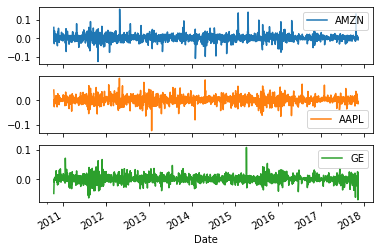

In [11]:
# Visualize change in Amazon, Apple, and GE stock prices
plot_cols = ['AMZN', 'AAPL', 'GE']
plot_features = df_dji[plot_cols]
plot_features.index = df_dji['Date']
_ = plot_features.plot(subplots=True)


# <center><span style="color:blue">*Split Dataset & Normalization*</span></center>

In [12]:
# Split the dataset into 60% train, 20% test, and 20% validation
samples_count, features_count = df_dji.shape

numeric_formats = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']


df_dji_train = df_dji.select_dtypes(include=numeric_formats).iloc[:int(samples_count*0.6), :]
df_dji_test = df_dji.select_dtypes(include=numeric_formats).iloc[int(samples_count*0.6): int(samples_count*0.8), :]
df_dji_val = df_dji.select_dtypes(include=numeric_formats).iloc[int(samples_count*0.8):, :]

df_nasdaq_train = df_nasdaq.select_dtypes(include=numeric_formats).iloc[:int(samples_count*0.6), :]
df_nasdaq_test = df_nasdaq.select_dtypes(include=numeric_formats).iloc[int(samples_count*0.6): int(samples_count*0.8), :]
df_nasdaq_val = df_nasdaq.select_dtypes(include=numeric_formats).iloc[int(samples_count*0.8):, :]

df_nyse_train = df_nyse.select_dtypes(include=numeric_formats).iloc[:int(samples_count*0.6), :]
df_nyse_test = df_nyse.select_dtypes(include=numeric_formats).iloc[int(samples_count*0.6): int(samples_count*0.8), :]
df_nyse_val = df_nyse.select_dtypes(include=numeric_formats).iloc[int(samples_count*0.8):, :]

df_russell_train = df_russell.select_dtypes(include=numeric_formats).iloc[:int(samples_count*0.6), :]
df_russell_test = df_russell.select_dtypes(include=numeric_formats).iloc[int(samples_count*0.6):int(samples_count*0.8), :]
df_russell_val = df_russell.select_dtypes(include=numeric_formats).iloc[int(samples_count*0.8):, :]

df_sp_train = df_sp.select_dtypes(include=numeric_formats).iloc[:int(samples_count*0.6), :]
df_sp_test = df_sp.select_dtypes(include=numeric_formats).iloc[int(samples_count*0.6): int(samples_count*0.8), :]
df_sp_val = df_sp.select_dtypes(include=numeric_formats).iloc[int(samples_count*0.8):, :]


print('Training/Testing/Validating Dataframe Dimensions: ')
print(df_nyse_train.shape, df_nyse_test.shape, df_nyse_val.shape)

Training/Testing/Validating Dataframe Dimensions: 
(1071, 82) (357, 82) (357, 82)


In [13]:
# Normalize data using the Z-score

df_dji_test = (df_dji_test - df_dji_train.mean()) / df_dji_train.std()
df_dji_val = (df_dji_val - df_dji_train.mean()) / df_dji_train.std()
df_dji_train = (df_dji_train - df_dji_train.mean()) / df_dji_train.std()

df_nasdaq_test = (df_nasdaq_test - df_nasdaq_train.mean()) / df_nasdaq_train.std()
df_nasdaq_val = (df_nasdaq_val - df_nasdaq_train.mean()) / df_nasdaq_train.std()
df_nasdaq_train = (df_nasdaq_train - df_nasdaq_train.mean()) / df_nasdaq_train.std()

df_nyse_test = (df_nyse_test - df_nyse_train.mean()) / df_nyse_train.std()
df_nyse_val = (df_nyse_val - df_nyse_train.mean()) / df_nyse_train.std()
df_nyse_train = (df_nyse_train - df_nyse_train.mean()) / df_nyse_train.std()

df_russell_test = (df_russell_test - df_russell_train.mean()) / df_russell_train.std()
df_russell_val = (df_russell_val - df_russell_train.mean()) / df_russell_train.std()
df_russell_train = (df_russell_train - df_russell_train.mean()) / df_russell_train.std()

df_sp_test = (df_sp_test - df_sp_train.mean()) / df_sp_train.std()
df_sp_val = (df_sp_val - df_sp_train.mean()) / df_sp_train.std()
df_sp_train = (df_sp_train - df_sp_train.mean()) / df_sp_train.std()

print('Task completed')

Task completed


In [14]:
df_dji_test.head()

,Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,ROC_15,ROC_20,...,NZD,silver-F,RUSSELL-F,S&P-F,CHF,Dollar index-F,Dollar index,wheat-F,XAG,XAU
1270,1.709861,0.022084,-0.028965,1.193832,-0.742637,-1.252094,-0.498731,-0.159109,-1.248558,-0.742833,...,-2.481860,0.663901,-0.391301,0.291161,-0.496930,1.042064,1.229675,0.412355,0.763661,1.164086
1271,1.729236,0.011178,0.199208,-0.027807,1.192478,-0.744394,-0.300966,0.234268,-1.147540,-0.721086,...,-1.579581,0.622961,-0.322716,0.433000,-2.098559,-0.518482,-0.396751,0.069000,0.404998,-0.029366
1272,1.858096,-0.086715,1.618195,0.200517,-0.029176,1.192134,1.048411,0.336692,-0.560234,-0.540347,...,-0.838905,0.577472,1.658622,1.446138,1.540436,2.797679,2.789262,-0.185915,0.562810,0.567360
1273,1.787945,0.035318,-0.948871,1.620445,0.199150,-0.030413,0.948976,-0.721187,-0.527872,-0.885598,...,-0.825438,-0.236781,-0.330337,-0.671319,1.293126,1.540572,1.563872,-0.414818,-0.121041,-0.476910
1274,1.790971,0.019111,-0.013591,-0.948323,1.619096,0.198081,0.380574,-0.324077,-0.534933,-0.885302,...,-0.542635,-0.887273,1.582417,0.412738,2.977191,0.088397,0.048845,-0.909041,-0.957922,-0.898128


# <center><span style="color:blue">*Window Dataset*</span></center>

In [15]:
# This WindowGenerator is desiged specifically for single-step model ONLY
class WindowGenerator():  
    def __init__(self, input_width, label_width, offset,
                 df_train, df_val, df_test,
                 label_columns=None):
    # Store the class inputs.
        self.train_data = df_train
        self.validation_data = df_val
        self.test_data = df_test
        self.input_width = input_width
        self.label_width = 1    # Force label_width to 1
        self.offset = 1         # Force offset to 1

    # Work out the label column indices.
        self.column_indices = {name: i 
                               for i, name in enumerate(df_train.columns)}
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: self.column_indices[name]
                                          for name in label_columns}

        self.total_window_size = input_width + offset
        self.input_indices = np.arange(self.total_window_size)[slice(0, self.input_width)]

        self.label_start = self.total_window_size - self.label_width
        self.label_indices = np.arange(self.total_window_size)[slice(self.label_start, None)]


    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s) & index(s): {self.label_columns_indices}'])
    


# The goal is predicting if the target(s) increases or decreases the following day
# For labels, we take the difference between targets' values of day t and of day t-1
# Values increase,        label=1
# Values decrease/remain, label=0

    def split_window(self, features):
        inputs = features[:, slice(0, self.input_width), :]
        labels = features[:, slice(self.label_start, None), :] - \
                 features[:, slice(self.label_start - 1, self.label_start), :]
        labels = tf.cast(labels > 0, dtype=tf.float32)
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
    # Slicing doesn't preserve static shape information, so set the shapes manually.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels


    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=0,
            batch_size=32,)
        ds = ds.map(self.split_window)
        return ds


# Reference on @property: https://www.programiz.com/python-programming/property
    @property
    def train(self):
        return self.make_dataset(self.train_data)

    @property
    def val(self):
        return self.make_dataset(self.validation_data)

    @property
    def test(self):
        return self.make_dataset(self.test_data)

In [16]:
# In the referenced paper, the authors were only interested in predicting motions of the index closing
# We use data from previous 60 days to predict the following day target

window_dji = WindowGenerator(input_width=60, label_width=1, offset=1,
                         df_train=df_dji_train, df_test=df_dji_test, df_val=df_dji_val,
                         label_columns=['Close'])

window_nasdaq = WindowGenerator(input_width=60, label_width=1, offset=1,
                         df_train=df_nasdaq_train, df_test=df_nasdaq_test, df_val=df_nasdaq_val,
                         label_columns=['Close'])

window_nyse = WindowGenerator(input_width=60, label_width=1, offset=1,
                         df_train=df_nyse_train, df_test=df_nyse_test, df_val=df_nyse_val,
                         label_columns=['Close'])

window_russell = WindowGenerator(input_width=60, label_width=1, offset=1,
                         df_train=df_russell_train, df_test=df_russell_test, df_val=df_russell_val,
                         label_columns=['Close'])

window_sp = WindowGenerator(input_width=60, label_width=1, offset=1,
                         df_train=df_sp_train, df_test=df_sp_test, df_val=df_sp_val,
                         label_columns=['Close'])


In [17]:
train_window = window_dji.train
test_window = window_dji.test
val_window = window_dji.val

for window in [window_nasdaq, window_nyse, window_russell, window_sp]:
    train_window = train_window.zip(window.train)
    test_window = test_window.zip(window.test)
    val_window = val_window.zip(window.val)

In [18]:
# Examine the created window

for inputs, labels in train_window.take(1):
    print('Inputs shape: {}'.format(inputs.shape))
    print('Labels shape: {} \n'.format(labels.shape))
    print('Example labels (each row is one instance): ')
    print(tf.reshape(labels, [1, -1]))

Inputs shape: (32, 60, 82)
Labels shape: (32, 1, 1) 

Example labels (each row is one instance): 
tf.Tensor(
[[1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1.
  0. 1. 1. 1. 0. 0. 0. 1.]], shape=(1, 32), dtype=float32)


# <center><span style="color:blue">*2D CNN Model*</span></center>

In [19]:
model_2D = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=8,
                           kernel_size=1,
                           kernel_initializer='GlorotUniform',
                           activation='relu'),    # out_shape = (60, 16)
    tf.keras.layers.Conv1D(filters=8,
                           kernel_size=3,
                           kernel_initializer='GlorotUniform',
                           activation='relu'),    # out_shape = (58, 16)
    tf.keras.layers.MaxPool1D(pool_size=2,
                              strides=None,
                              padding='valid'),    # out_shape = (29, 16)
    tf.keras.layers.Conv1D(filters=8,
                           kernel_size=3,
                           kernel_initializer='GlorotUniform',
                           activation='relu'),    # out_shape = (27, 16)
    tf.keras.layers.MaxPool1D(pool_size=2,
                              strides=None, 
                              padding='valid'),    # out_shape = (13, 16)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(104, kernel_initializer='GlorotUniform', activation='relu'),
    tf.keras.layers.Dense(units=1, kernel_initializer='GlorotUniform', activation='sigmoid')
])

In [20]:
# Build an optimizer that reduces the learning rate over time

steps_per_epoch = 2

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=0.01 ,
                                                             decay_steps=steps_per_epoch, 
                                                             decay_rate=1, 
                                                             staircase=False, 
                                                             name=None)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

In [21]:
MAX_EPOCHS = 25

def compile_and_fit(model, train_window, test_window, patience=10):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                      patience=patience,
                                                      mode='min')
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    model.compile(optimizer=get_optimizer(),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

    history = model.fit(train_window, epochs=MAX_EPOCHS,
                        validation_data=test_window,
                        callbacks=[tensorboard_callback, early_stopping], verbose=1)
    return history

In [195]:
history = dict()
history['2D_Model'] = compile_and_fit(model_2D, train_window, test_window)

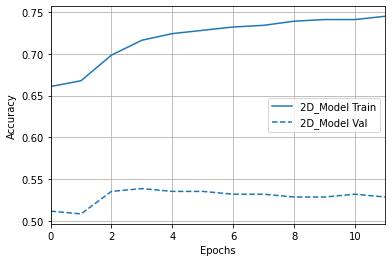

In [196]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=0)
plotter.plot(history)

In [197]:
f1_macro_score_2D = []
precision_2D = []
recall_2D = []

for window in [window_dji, window_nasdaq, window_nyse, window_russell, window_sp]:
    validation_labels = np.empty(shape=[0, 1])
    for inputs, labels in window.val:
        validation_labels = np.append(validation_labels, labels.numpy().reshape(-1, 1), axis=0)

        predictions = (model_2D.predict(window.val) > 0.5).astype(float)
    
    f1_macro_score_2D.append(metrics.f1_score(validation_labels, predictions, average='macro'))
    precision_2D.append(metrics.precision_score(validation_labels, predictions, average='macro')) 
    recall_2D.append(metrics.recall_score(validation_labels, predictions, average='macro'))

keys = ['DJI', 'NASDAQ', 'NYSE', 'RUSSELL', 'S&P500']
f1_macro_score_2D = {keys[i]: f1_macro_score_2D[i] for i in range(len(keys))}
precision_2D = {keys[i]: precision_2D[i] for i in range(len(keys))}
recall_2D = {keys[i]: recall_2D[i] for i in range(len(keys))}

In [ ]:
#%load_ext tensorboard
#%reload_ext tensorboard
#%tensorboard --logdir logs/fit

In [198]:
print('2D CNN Model Assessment')

print('\nAverage F-Macro Score: {:.2f}'.format(np.mean(list(f1_macro_score_2D.values()))))
for key, value in f1_macro_score_2D.items():
    print('\t', key, ': {:.2f}'.format(value))

print('\nAverage Precision: {:.2f}'.format(np.mean(list(precision_2D.values()))))
for key, value in precision_2D.items():
    print('\t', key, ': {:.2f}'.format(value))

print('\nAverage Recall: {:.2f}'.format(np.mean(list(recall_2D.values()))))
for key, value in recall_2D.items():
    print('\t', key, ': {:.2f}'.format(value))

2D CNN Model Assessment

Average F-Macro Score: 0.52
	 DJI : 0.50
	 NASDAQ : 0.53
	 NYSE : 0.54
	 RUSSELL : 0.52
	 S&P500 : 0.54

Average Precision: 0.54
	 DJI : 0.51
	 NASDAQ : 0.57
	 NYSE : 0.54
	 RUSSELL : 0.52
	 S&P500 : 0.55

Average Recall: 0.54
	 DJI : 0.51
	 NASDAQ : 0.56
	 NYSE : 0.54
	 RUSSELL : 0.52
	 S&P500 : 0.55


In [ ]:
# Algorithm results are quite consistent with what was reported in the reference literature

# <center><span style="color:blue">*3D CNN Model*</span></center>

In [79]:
train_matrix = np.array([df_dji_train.to_numpy(),
                         df_nasdaq_train.to_numpy(),
                         df_nyse_train.to_numpy(),
                         df_russell_train.to_numpy(),
                         df_sp_train.to_numpy()]).transpose([1, 0, 2])

test_matrix = np.array([df_dji_test.to_numpy(),
                        df_nasdaq_test.to_numpy(),
                        df_nyse_test.to_numpy(),
                        df_russell_test.to_numpy(),
                        df_sp_test.to_numpy()]).transpose([1, 0, 2])

val_matrix = np.array([df_dji_val.to_numpy(),
                       df_nasdaq_val.to_numpy(),
                       df_nyse_val.to_numpy(),
                       df_russell_val.to_numpy(),
                       df_sp_val.to_numpy()]).transpose([1, 0, 2])

market_index_dict = {'DJI':0, 'NASDAQ':1, 'NYSE':2, 'RUSSELL':3, 'S&P500':4}
print('Market Labels-Index: {}'.format(market_index_dict))
print('Matrix Dimensions: \t\t(Time, Market, Features)')
print('Training Matrix Dimension:\t{}'.format(train_matrix.shape))
print('Testing Matrix Dimension:\t{}'.format(test_matrix.shape))
print('Validation Matrix Dimension:\t{}'.format(val_matrix.shape))

Market Labels-Index: {'DJI': 0, 'NASDAQ': 1, 'NYSE': 2, 'RUSSELL': 3, 'S&P500': 4}
Matrix Dimensions: 		(Time, Market, Features)
Training Matrix Dimension:	(1071, 5, 82)
Testing Matrix Dimension:	(357, 5, 82)
Validation Matrix Dimension:	(357, 5, 82)


In [101]:
# This WindowGenerator is desiged specifically for single-step model ONLY
class WindowGenerator_3D():  
    def __init__(self, input_width, label_width, offset,
                 train_matrix, test_matrix, val_matrix,
                 market_index,
                 label_column_index):
    # Store the class inputs.
        self.input_width = input_width
        self.label_width = 1    # Force label_width to 1
        self.offset = 1         # Force offset to 1
        self.train_data = train_matrix
        self.test_data = test_matrix
        self.validation_data = val_matrix
        self.market_index = market_index
        self.label_column_index = label_column_index
        

    # Work out the label column indices in each subframe.
        self.total_window_size = input_width + offset
        self.input_indices = list(np.arange(self.total_window_size)[slice(0, self.input_width)])

        self.label_start = self.total_window_size - self.label_width
        self.label_indices = list(np.arange(self.total_window_size)[slice(self.label_start, None)])


    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column index: {self.label_column_index}',
            f'Market index: {self.market_index}'])
    


# The goal is predicting if the target(s) increases or decreases the following day
# For labels, we take the difference between targets' values of day t and of day t-1
# Values increase,        label=1
# Values decrease/remain, label=0

    def split_window(self, data):
        inputs = tf.slice(data, [0, 0, 0, 0], [-1, self.input_width, -1 , -1]) 
        labels = tf.slice(data, [0, self.input_width, self.market_index, self.label_column_index],
                          [-1, self.label_width, 1, 1]) - \
                 tf.slice(data, [0, self.input_width-1, self.market_index, self.label_column_index],
                          [-1, self.label_width, 1, 1])
        labels = tf.reshape(tf.cast(labels > 0, dtype=tf.float32), [-1, 1])

        return inputs, labels


    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=0,
            batch_size=32,)
        ds = ds.map(self.split_window)
        return ds


# Reference on @property: https://www.programiz.com/python-programming/property
    @property
    def train(self):
        return self.make_dataset(self.train_data)

    @property
    def val(self):
        return self.make_dataset(self.validation_data)

    @property
    def test(self):
        return self.make_dataset(self.test_data)

In [96]:
dji_window = WindowGenerator_3D(input_width=60, label_width=1, offset=1,
                                train_matrix=train_matrix, test_matrix=test_matrix, val_matrix=val_matrix,
                                market_index=market_index_dict['DJI'],
                                label_column_index=0)
dji_window

Total window size: 61
Input indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
Label indices: [60]
Label column index: 0

In [97]:
# Examine the created window

for inputs, labels in dji_window.val.take(1):
    print('Inputs shape: {}'.format(inputs.shape))
    print('Labels shape: {} \n'.format(labels.shape))
    print('5 Example labels: ')
    print(labels[:5])

Inputs shape: (32, 60, 5, 82)
Labels shape: (32, 1) 

5 Example labels: 
tf.Tensor(
[[0.]
 [1.]
 [0.]
 [0.]
 [1.]], shape=(5, 1), dtype=float32)


In [98]:
model_3D = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=8,
                           kernel_size=(1, 1),
                           kernel_initializer='GlorotUniform',
                           activation='relu'),    # out_shape = (60, 16)
    tf.keras.layers.Conv2D(filters=8,
                           kernel_size=(3, 5),
                           kernel_initializer='GlorotUniform',
                           activation='relu'),    # out_shape = (58, 16)
    tf.keras.layers.MaxPool2D(pool_size=(2, 1),
                              strides=None,
                              padding='valid'),    # out_shape = (29, 16)
    tf.keras.layers.Conv2D(filters=8,
                           kernel_size=(3, 1),
                           kernel_initializer='GlorotUniform',
                           activation='relu'),    # out_shape = (27, 16)
    tf.keras.layers.MaxPool2D(pool_size=(2, 1),
                              strides=None, 
                              padding='valid'),    # out_shape = (13, 16)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, kernel_initializer='GlorotUniform', activation='relu'),
    tf.keras.layers.Dense(units=1, kernel_initializer='GlorotUniform', activation='sigmoid')
])

In [89]:
# Build an optimizer that reduces the learning rate over time

steps_per_epoch = 2

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=0.01 ,
                                                             decay_steps=steps_per_epoch, 
                                                             decay_rate=1, 
                                                             staircase=False, 
                                                             name=None)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

In [90]:
MAX_EPOCHS = 25

def compile_and_fit(model, train_window, test_window, patience=10):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                      patience=patience,
                                                      mode='min')
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    model.compile(optimizer=get_optimizer(),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

    history = model.fit(train_window, epochs=MAX_EPOCHS,
                        validation_data=test_window,
                        callbacks=[tensorboard_callback, early_stopping], verbose=0)
    return history

In [48]:
def results_evaluation(model, window):
    validation_labels = np.empty(shape=[0, 1])
    for inputs, labels in window:
        validation_labels = np.append(validation_labels, labels.numpy().reshape(-1, 1), axis=0)
    predictions = (model.predict(window) > 0.5).astype(float)
    
    f1_macro_score = metrics.f1_score(validation_labels, predictions, average='macro')
    precision = metrics.precision_score(validation_labels, predictions, average='macro')
    recall = metrics.recall_score(validation_labels, predictions, average='macro')
    
    return f1_macro_score, precision, recall

In [154]:
history = dict()
history['3D_Model'] = compile_and_fit(model_3D, dji_window.train, dji_window.test)

f1_macro_score for DJI model: 0.50



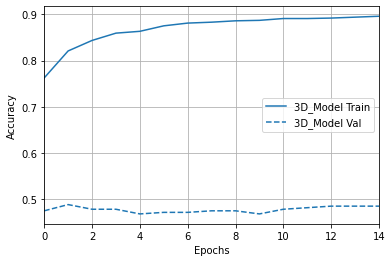

In [155]:
f1_macro_score = dict()
precision = dict()
recall = dict()

f1, pre, rec = results_evaluation(model_3D, dji_window.val)
f1_macro_score['DJI'] = f1
precision['DJI'] = pre
recall['DJI'] = rec

print('f1_macro_score for DJI model: {:.2f}\n'.format(f1))

plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=0)
plotter.plot(history)

In [158]:
nasdaq_window = WindowGenerator_3D(input_width=60, label_width=1, offset=1,
                                train_matrix=train_matrix, test_matrix=test_matrix, val_matrix=val_matrix,
                                market_index=market_index_dict['NASDAQ'],
                                label_column_index=0)

history['3D_Model'] = compile_and_fit(model_3D, nasdaq_window.train, nasdaq_window.test)

f1_macro_score for NASDAQ model: 0.49



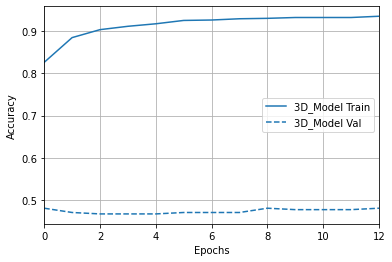

In [159]:
f1, pre, rec = results_evaluation(model_3D, nasdaq_window.val)
f1_macro_score['NASDAQ'] = f1
precision['NASDAQ'] = pre
recall['NASDAQ'] = rec

print('f1_macro_score for NASDAQ model: {:.2f}\n'.format(f1))

plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=0)
plotter.plot(history)

In [160]:
nyse_window = WindowGenerator_3D(input_width=60, label_width=1, offset=1,
                                 train_matrix=train_matrix, test_matrix=test_matrix, val_matrix=val_matrix,
                                 market_index=market_index_dict['NYSE'],
                                 label_column_index=0)

history['3D_Model'] = compile_and_fit(model_3D, nyse_window.train, nyse_window.test)
print('Finished training')

Finished training


f1_macro_score for NYSE model: 0.49



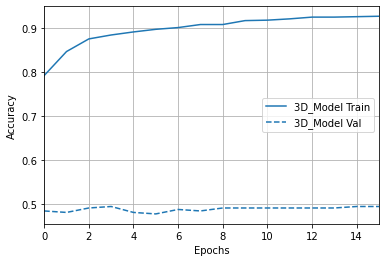

In [161]:
f1, pre, rec = results_evaluation(model_3D, nyse_window.val)
f1_macro_score['NYSE'] = f1
precision['NYSE'] = pre
recall['NYSE'] = rec

print('f1_macro_score for NYSE model: {:.2f}\n'.format(f1))

plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=0)
plotter.plot(history)

In [162]:
russell_window = WindowGenerator_3D(input_width=60, label_width=1, offset=1,
                                    train_matrix=train_matrix, test_matrix=test_matrix, val_matrix=val_matrix,
                                    market_index=market_index_dict['RUSSELL'],
                                    label_column_index=0)

history['3D_Model'] = compile_and_fit(model_3D, russell_window.train, russell_window.test)
print('Finished training')

Finished training


f1_macro_score for RUSSELL model: 0.50



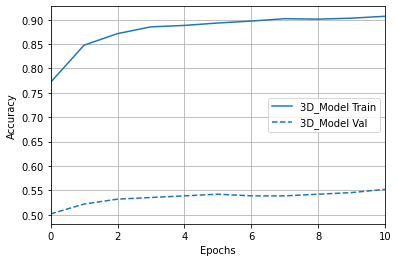

In [163]:
f1, pre, rec = results_evaluation(model_3D, russell_window.val)
f1_macro_score['RUSSELL'] = f1
precision['RUSSELL'] = pre
recall['RUSSELL'] = rec

print('f1_macro_score for RUSSELL model: {:.2f}\n'.format(f1))

plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=0)
plotter.plot(history)

In [166]:
sp_window = WindowGenerator_3D(input_width=60, label_width=1, offset=1,
                               train_matrix=train_matrix, test_matrix=test_matrix, val_matrix=val_matrix,
                               market_index=market_index_dict['S&P500'],
                               label_column_index=0)

history['3D_Model'] = compile_and_fit(model_3D, sp_window.train, sp_window.test)
print('Finished training')

Finished training


f1_macro_score for S&P500 model: 0.51



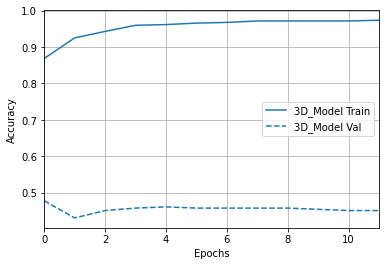

In [167]:
f1, pre, rec = results_evaluation(model_3D, sp_window.val)
f1_macro_score['S&P500'] = f1
precision['S&P500'] = pre
recall['S&P500'] = rec

print('f1_macro_score for S&P500 model: {:.2f}\n'.format(f1))

plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=0)
plotter.plot(history)

In [168]:
print('3D CNN Model Assessment')

print('\nAverage F-Macro Score: {:.2f}'.format(np.mean(list(f1_macro_score.values()))))
for key, value in f1_macro_score.items():
    print('\t', key, ': {:.2f}'.format(value))

print('\nAverage Precision: {:.2f}'.format(np.mean(list(precision.values()))))
for key, value in precision.items():
    print('\t', key, ': {:.2f}'.format(value))

print('\nAverage Recall: {:.2f}'.format(np.mean(list(precision.values()))))
for key, value in recall.items():
    print('\t', key, ': {:.2f}'.format(value))

3D CNN Model Assessment

Average F-Macro Score: 0.50
	 DJI : 0.50
	 NASDAQ : 0.49
	 NYSE : 0.49
	 RUSSELL : 0.50
	 S&P500 : 0.51

Average Precision: 0.51
	 DJI : 0.50
	 NASDAQ : 0.51
	 NYSE : 0.49
	 RUSSELL : 0.56
	 S&P500 : 0.51

Average Recall: 0.51
	 DJI : 0.50
	 NASDAQ : 0.51
	 NYSE : 0.49
	 RUSSELL : 0.54
	 S&P500 : 0.51
